In [ ]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tcn import TCN, tcn_full_summary
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import mode

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/combined_output.csv')

In [ ]:


# Assuming the features are in columns except the last one which is the target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


# Encode the string labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)



In [ ]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the number of cases per sample (as per your previous setup)
num_cases_per_sample = 10
num_samples = X.shape[0] // num_cases_per_sample

# Reshape X to have samples of 100 cases each
X_samples = X[:num_samples * num_cases_per_sample].reshape(num_samples, num_cases_per_sample, -1)
y_samples = y[:num_samples * num_cases_per_sample].reshape(num_samples, num_cases_per_sample)



In [ ]:
# Majority voting for labels
from scipy.stats import mode
y_samples = mode(y_samples, axis=1)[0].flatten()

# One-hot encode the labels
num_classes = len(np.unique(y_samples))
y_samples_one_hot = to_categorical(y_samples, num_classes=num_classes)



In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_samples, y_samples_one_hot, test_size=0.2, random_state=42)

In [ ]:
# Build the TCN model
model = Sequential([
    TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], padding='causal', input_shape=(num_cases_per_sample, X.shape[1])),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_full_summary(model, expand_residual_blocks=False)



Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                90176     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
Total params: 100560 (392.81 KB)
Trainable params: 100560 (392.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
5409/5409 [==============================] - 136s 24ms/step - loss: 0.7433 - accuracy: 0.7081 - val_loss: 0.4316 - val_accuracy: 0.8288
Epoch 2/50
5409/5409 [==============================] - 115s 21ms/step - loss: 0.3463 - accuracy: 0.8676 - val_loss: 0.2364 - val_accuracy: 0.9052
Epoch 3/50
5409/5409 [==============================] - 123s 23ms/step - loss: 0.2477 - accuracy: 0.9078 - val_loss: 0.1782 - val_accuracy: 0.9286
Epoch 4/50
5409/5409 [==============================] - 119s 22ms/step - loss: 0.1875 - accuracy: 0.9348 - val_loss: 0.1494 - val_accuracy: 0.9428
Epoch 5/50
5409/5409 [==============================] - 118s 22ms/step - loss: 0.1512 - accuracy: 0.9494 - val_loss: 0.0912 - val_accuracy: 0.9688
Epoch 6/50
5409/5409 [==============================] - 121s 22ms/step - loss: 0.1346 - accuracy: 0.9572 - val_loss: 0.1194 - val_accuracy: 0.9603
Epoch 7/50
5409/5409 [==============================] - 116s 22ms/step - loss: 0.1157 - accuracy: 0.9634 - val_loss: 0

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


1353/1353 [==============================] - 12s 9ms/step - loss: 0.0953 - accuracy: 0.9732
Test Accuracy: 0.9732


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                90176     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
Total params: 100560 (392.81 KB)
Trainable params: 100560 (392.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


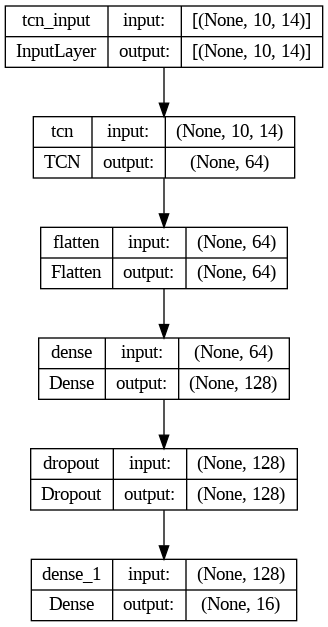

In [ ]:
# Plot model structure
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
label_mapping = {
    'F0L': 0, 'F0M': 1, 'F1L': 2, 'F1M': 3, 'F2L': 4, 'F2M': 5, 'F3L': 6, 'F3M': 7,
    'F4L': 8, 'F4M': 9, 'F5L': 10, 'F5M': 11, 'F6L': 12, 'F6M': 13, 'F7L': 14, 'F7M': 15
}

In [ ]:
# label_mapping = {'NF':0, 'LG':1, 'LL':2, 'LLG':3, 'LLL':4, 'LLLG':5}

1353/1353 [==============================] - 8s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2867
           1       0.97      0.99      0.98      2762
           2       0.96      0.99      0.98      2640
           3       1.00      1.00      1.00      2704
           4       0.98      0.94      0.96      2769
           5       1.00      1.00      1.00      2856
           6       0.94      0.88      0.91      2102
           7       0.99      0.92      0.95      1394
           8       1.00      1.00      1.00      2910
           9       1.00      1.00      1.00      2896
          10       0.88      0.96      0.91      2848
          11       0.98      0.99      0.99      2871
          12       0.99      0.96      0.97      2957
          13       1.00      0.99      1.00      2950
          14       0.91      0.95      0.93      2888
          15       1.00      0.99      1.00      2856

    accuracy           

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of labels (6).

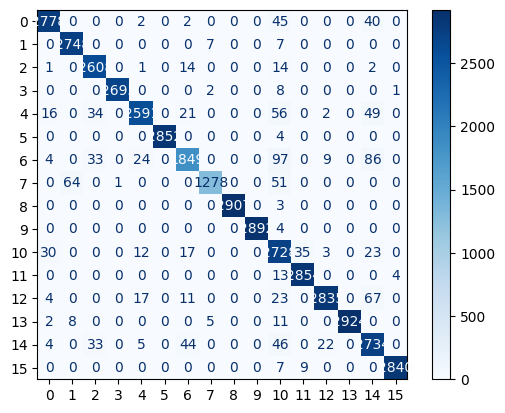

In [ ]:
# Evaluate the model
y_pred_one_hot = model.predict(X_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_test_labels, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
print(conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[key for key, val in label_mapping.items()])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()